### importing dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2 
from skimage import io, color, exposure, filters
import seaborn as sns

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report

In [3]:
# Check if TensorFlow can see your hardware
print("TensorFlow version:", tf.__version__)
print("GPU Available: ", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.20.0
GPU Available:  []


### Dataset Preprocessing

In [5]:
# Parameters
INPUT_SIZE = 128 # 264
BATCH_SIZE = 16 # 64, I was trying to prevent "ResourceExhaustedError"

SEED = 11
np.random.seed(SEED)
tf.random.set_seed(SEED)

path = "C:/Users/Gavela Maculuve/PycharmProjects/Projects_/CNN/BreastCancer/images"
trainpath = path + '/train'
validpath = path + '/valid'
testpath = path + '/test'

classes = ['Benign', 'Malignant']
NUMCLASSES = len(classes)

In [8]:
def preprocess(img):
    img = img.astype('float32')
    
    min_val = np.min(img)
    max_val = np.max(img)
    
    img = (img-min_val)/(max_val - min_val + 1e-7)
    img = img-0.5
    
    return img

In [9]:
img = io.imread(trainpath + '/Benign/36_1161539227_png.rf.4ffb84ae9f0a6aca49a2d5e2403de5d9.jpg')
gray = preprocess(img)
gray.shape

(640, 640, 3)

#### Data Augment

In [10]:
# Image Data Generator
# I believe that this creates the variability in the images, so they image are not uniform
train_datagen = ImageDataGenerator(
    rotation_range = 5,
    width_shift_range = 0.05,
    height_shift_range = 0.05,
    brightness_range = None,
    shear_range = 0.1,
    zoom_range = 0.05,
    fill_mode = "nearest",
    preprocessing_function = preprocess,
    horizontal_flip = True
    # vertical_flip = False,
    # data_format = None,
    # validation_split = 0.0,
    # dtype = None
    # rescale = 1./255,
    # cval = 0.0,
    # channel_shift_range = 0.0,
    # featurewise_center = False,
    # samplewise_center = False,
    # featurewise_std_normalization = False,
    # samplewise_std_normalization = False,
    # zca_epsilon = 1e-06,
)

val_datagen = ImageDataGenerator(
    # rescale = 1./255,
    preprocessing_function = preprocess # spin back
)


In [11]:
training_set = train_datagen.flow_from_directory(
    directory = trainpath,
    # subset = 'training',
    target_size = (INPUT_SIZE, INPUT_SIZE),
    batch_size = BATCH_SIZE,
    color_mode = "grayscale",
    class_mode = "categorical",
    shuffle = True,
    seed = SEED
)

validation_set = val_datagen.flow_from_directory(
    directory = validpath,
    # subset = 'validation',
    target_size = (INPUT_SIZE, INPUT_SIZE),
    batch_size = BATCH_SIZE,
    color_mode = "grayscale",
    class_mode = "categorical",
    shuffle = True,
    seed = SEED
)

Found 3111 images belonging to 2 classes.
Found 896 images belonging to 2 classes.


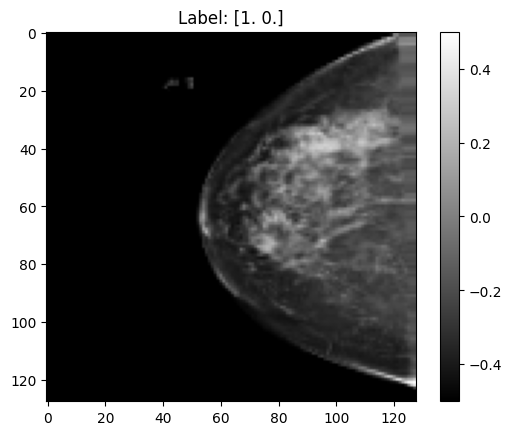

In [12]:
# Get one batch of images
images, labels = next(training_set)

# Show the first image in the batch
plt.imshow(images[0].reshape(128, 128), cmap='gray')
plt.title(f"Label: {labels[0]}")
plt.colorbar() # This will show if values are between -0.5 and 0.5
plt.show()

### Model 1

In [39]:
model = Sequential() # this is like a stacker for the layers (lego bricks base)

model.add(InputLayer(shape = [INPUT_SIZE, INPUT_SIZE, 1])) # adding batch dimension

model.add(Conv2D(filters = 32, kernel_size = 3, strides = 2, padding = 'same', activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=2, padding = 'same')) # downsample the feature maps
model.add(Dropout(0.2)) # prevent overfitting

model.add(Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=2, padding = 'same')) # downsample the feature maps
model.add(Dropout(0.3)) # prevent overfitting

model.add(Conv2D(filters = 128, kernel_size = 3, strides = 1, padding = 'same', activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=2, padding = 'same')) # downsample the feature maps
model.add(Dropout(0.4)) # prevent overfitting

# model.add(Conv2D(filters = 128, kernel_size = 3, strides = 1, padding = 'same', activation = 'relu'))
# model.add(BatchNormalization())
# model.add(MaxPool2D(pool_size=2, padding = 'same')) # downsample the feature maps
# model.add(Dropout(0.2)) # prevent overfitting

# model.add(Flatten()) # 2D -> 1D
model.add(GlobalAveragePooling2D())

model.add(Dense(128, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(NUMCLASSES, activation = 'softmax'))

optimizer = Adam(learning_rate=1e-5, clipnorm=1.0)
model.compile(optimizer = optimizer, loss ='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┓
┃ Layer (type)                       ┃ Output Shape              ┃        Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)                  │ (None, 64, 64, 32)        │            320 │
├────────────────────────────────────┼───────────────────────────┼────────────────┤
│ batch_normalization_13             │ (None, 64, 64, 32)        │            128 │
│ (BatchNormalization)               │                           │                │
├────────────────────────────────────┼───────────────────────────┼────────────────┤
│ max_pooling2d_9 (MaxPooling2D)     │ (None, 32, 32, 32)        │              0 │
├────────────────────────────────────┼───────────────────────────┼────────────────┤
│ dropout_16 (Dropout)               │ (None, 32, 32, 32)        │              0 │
├────────────────────────────────────┼───────────────────────────┼────────────────┤
│ conv2d_10 (Conv2D)                 │ (None, 32, 32, 64)        │         18,496 │
├────────────────────────────────────┼───────────────────────────┼────────────────┤
│ batch_normalization_14             │ (None, 32, 32, 64)        │            256 │
│ (BatchNormalization)               │                           │                │
├────────────────────────────────────┼───────────────────────────┼────────────────┤
│ max_pooling2d_10 (MaxPooling2D)    │ (None, 16, 16, 64)        │              0 │
├────────────────────────────────────┼───────────────────────────┼────────────────┤
│ dropout_17 (Dropout)               │ (None, 16, 16, 64)        │              0 │
├────────────────────────────────────┼───────────────────────────┼────────────────┤
│ conv2d_11 (Conv2D)                 │ (None, 16, 16, 128)       │         73,856 │
├────────────────────────────────────┼───────────────────────────┼────────────────┤
│ batch_normalization_15             │ (None, 16, 16, 128)       │            512 │
│ (BatchNormalization)               │                           │                │
├────────────────────────────────────┼───────────────────────────┼────────────────┤
│ max_pooling2d_11 (MaxPooling2D)    │ (None, 8, 8, 128)         │              0 │
├────────────────────────────────────┼───────────────────────────┼────────────────┤
│ dropout_18 (Dropout)               │ (None, 8, 8, 128)         │              0 │
├────────────────────────────────────┼───────────────────────────┼────────────────┤
│ global_average_pooling2d_4         │ (None, 128)               │              0 │
│ (GlobalAveragePooling2D)           │                           │                │
├────────────────────────────────────┼───────────────────────────┼────────────────┤
│ dense_12 (Dense)                   │ (None, 128)               │         16,512 │
├────────────────────────────────────┼───────────────────────────┼────────────────┤
│ batch_normalization_16             │ (None, 128)               │            512 │
│ (BatchNormalization)               │                           │                │
├────────────────────────────────────┼───────────────────────────┼────────────────┤
│ dropout_19 (Dropout)               │ (None, 128)               │              0 │
├────────────────────────────────────┼───────────────────────────┼────────────────┤
│ dense_13 (Dense)                   │ (None, 64)                │          8,256 │
├────────────────────────────────────┼───────────────────────────┼────────────────┤
│ dropout_20 (Dropout)               │ (None, 64)                │              0 │
├────────────────────────────────────┼───────────────────────────┼────────────────┤
│ dense_14 (Dense)                   │ (None, 2)                 │            130 │
└────────────────────────────────────┴───────────────────────────┴────────────────┘

 Total params: 118,978 (464.76 KB)

 Trainable params: 118,274 (462.01 KB)

 Non-trainable params: 704 (2.75 KB)

#### Train one

In [40]:
epochs = 15
history = model.fit(training_set, epochs = epochs, validation_data = validation_set)
model.save_weights("first-model-n-dec-26.weights.h5")
print("Saved model to disk after", epochs,"epochs.")

Epoch 1/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 47s 150ms/step - accuracy: 0.5047 - loss: 0.8901 - val_accuracy: 0.5000 - val_loss: 0.7238
Epoch 2/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 23s 119ms/step - accuracy: 0.5014 - loss: 0.8446 - val_accuracy: 0.5022 - val_loss: 0.8737
Epoch 3/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 29s 146ms/step - accuracy: 0.5059 - loss: 0.8290 - val_accuracy: 0.5000 - val_loss: 1.0473
Epoch 4/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 29s 149ms/step - accuracy: 0.5326 - loss: 0.8064 - val_accuracy: 0.4955 - val_loss: 1.1555
Epoch 5/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 22s 113ms/step - accuracy: 0.5101 - loss: 0.8228 - val_accuracy: 0.5179 - val_loss: 1.1725
Epoch 6/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 22s 112ms/step - accuracy: 0.5047 - loss: 0.8142 - val_accuracy: 0.5067 - val_loss: 1.2892
Epoch 7/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 22s 112ms/step - accuracy: 0.5304 - loss: 0.7932 - val_accuracy: 0.5134 - val_loss: 1.1827
Epoch 8/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 22s 111ms/step - accuracy: 0.5239 - loss: 0

In [15]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

##### first overviews

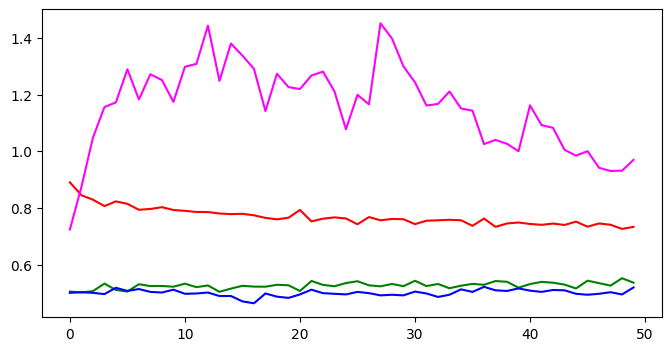

In [41]:
fig = plt.figure(figsize=(8,4))
plt.plot(history.history['loss'],color='red')
plt.plot(history.history['accuracy'],color='green')
plt.plot(history.history['val_loss'],color='magenta')
plt.plot(history.history['val_accuracy'],color='blue')
plt.show()

56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step


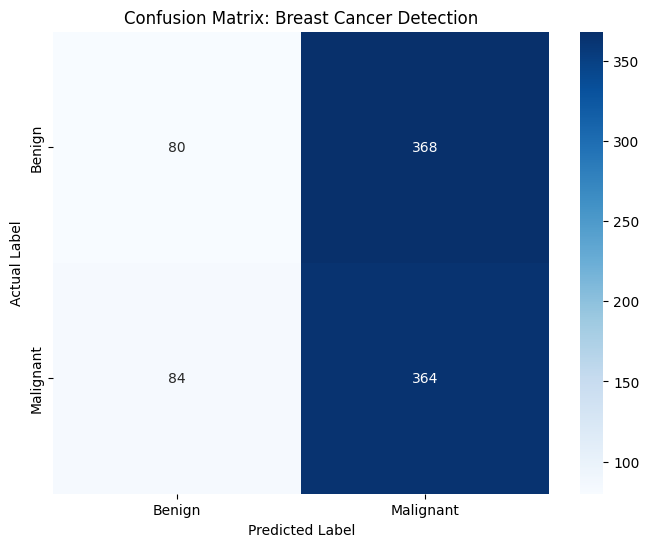

Classification Report
              precision    recall  f1-score   support

      Benign       0.49      0.18      0.26       448
   Malignant       0.50      0.81      0.62       448

    accuracy                           0.50       896
   macro avg       0.49      0.50      0.44       896
weighted avg       0.49      0.50      0.44       896



In [18]:
# 1. Get all true labels and predictions
# We turn off shuffle to ensure the labels match the predictions
validation_set.reset()
Y_pred = model.predict(validation_set)
y_pred = np.argmax(Y_pred, axis=1)
y_true = validation_set.classes

# 2. Create the Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# 3. Plotting
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix: Breast Cancer Detection')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# 4. Detailed Report
print('Classification Report')
print(classification_report(y_true, y_pred, target_names=classes))

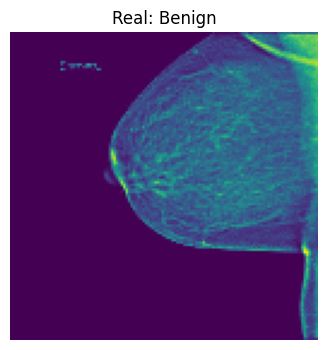

Real class: Benign
--- Top Predictions ---
Malignant: 78.77%
Benign: 21.23%


In [17]:
# Get random image
class_name = np.random.choice(classes)
folder_path = os.path.join(trainpath, class_name)
file_name = np.random.choice([f for f in os.listdir(folder_path) if f.lower() != 'thumbs.db'])
image_path = os.path.join(folder_path, file_name)

# Load and preprocess
img_gray = io.imread(image_path, as_gray = True)
img_resized = cv2.resize(img_gray, (INPUT_SIZE,INPUT_SIZE))
img = preprocess(img_resized)
# plt.imshow(img)

# plt.plot(exposure.histogram(img)[0])
img_tensor = img.astype('float32')
img_tensor = np.expand_dims(img_tensor, axis=(0, -1))

# Print what the top predicted class is
preds = model.predict(img_tensor, verbose = 0).flatten()

# print("Output Probabilities:", preds)
order = np.argsort(preds)[::-1]
reverse_class_labels = {v: k for k, v in training_set.class_indices.items()}

plt.figure(figsize=(6,4))
plt.imshow(img_resized)#, cmap = 'gray')
plt.title(f"Real: {class_name}")
plt.axis('off')
plt.show()

print('Real class:', class_name)
print(f"--- Top Predictions ---")
for i in range(len(classes)):
    idx = order[i]
    print(f"{reverse_class_labels[idx]}: {preds[idx]:.2%}")

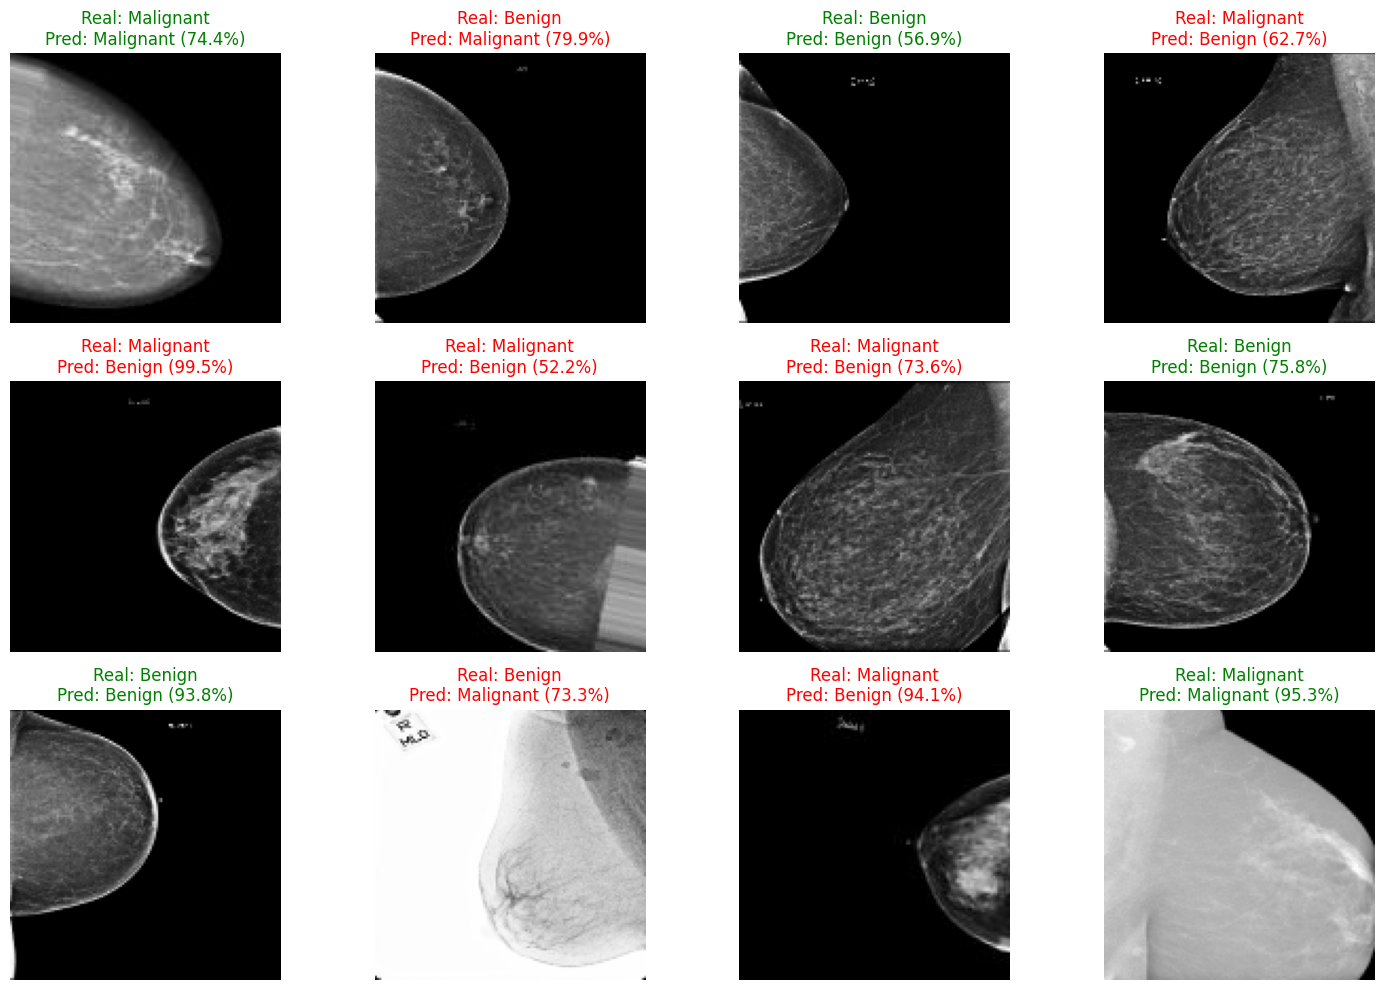

In [46]:
images, labels = next(validation_set) 

N = min(12, len(images)) # Show up to 12 images from the batch
fig = plt.figure(figsize=(15, 10))

for i in range(N):
    ax = fig.add_subplot(3, 4, i+1)
    
    # Get the actual dimensions of the image in the array
    h, w = images[i].shape[:2] 
    
    # Reshape dynamically: (1, height, width, 1)
    img_input = images[i].reshape(1, h, w, 1)
    
    # Make prediction
    pred = model.predict(img_input, verbose=0)
    
    # Convert one-hot labels back to text names
    real_label = classes[np.argmax(labels[i])] 
    pred_label = classes[np.argmax(pred)]
    confidence = np.max(pred) * 100
    
    # Display the mammogram
    ax.imshow(images[i].squeeze(), cmap='gray')
    
    # Color code the result: Green for match, Red for miss
    color = 'green' if real_label == pred_label else 'red'
    ax.set_title(f"Real: {real_label}\nPred: {pred_label} ({confidence:.1f}%)", color=color)
    ax.axis('off')

plt.tight_layout()
plt.show()

#### Train 2

In [25]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input, Concatenate, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# 2. Build Transfer Learning Model (MobileNetV2)
print("Building MobileNetV2 Transfer Learning model...")
# Base model pre-trained on ImageNet
base_model = MobileNetV2(weights='imagenet', include_top=False, 
                         input_shape=(INPUT_SIZE, INPUT_SIZE, 3))
base_model.trainable = False  # Freeze expert layers initially

# Custom Input for Grayscale
inputs = Input(shape=(INPUT_SIZE, INPUT_SIZE, 1))
# Convert 1 channel to 3 channels so MobileNetV2 can process it
x = Concatenate()([inputs, inputs, inputs]) 
x = base_model(x, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
outputs = Dense(2, activation='softmax')(x)

model_3 = Model(inputs, outputs)

# 3. Aggressive Class Weights (The fix for 7% Malignant Recall)
# We tell the model that missing a Malignant case is 5x worse than a Benign one
class_weights = {0: 1.0, 1: 5.0} 

model_3.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# 4. Professional Callbacks
early_stop_3 = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
reduce_lr_3 = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1, min_lr=1e-7)
checkpoint_3 = ModelCheckpoint('best_cancer_model_TL.keras', monitor='val_accuracy', save_best_only=True, verbose=1)

# 5. Training
print("Starting training...")
history_3 = model_3.fit(
    training_set,
    epochs=30,
    validation_data=validation_set,
    class_weight=None,
    callbacks=[early_stop_3, reduce_lr_3, checkpoint_3]
)

print("\nTraining Complete. Check the Val Accuracy to see if we passed 75%!")

Building MobileNetV2 Transfer Learning model...
Starting training...
Epoch 1/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.5245 - loss: 1.0575
Epoch 1: val_accuracy improved from None to 0.66406, saving model to best_cancer_model_TL.keras
195/195 ━━━━━━━━━━━━━━━━━━━━ 47s 223ms/step - accuracy: 0.5349 - loss: 1.0040 - val_accuracy: 0.6641 - val_loss: 0.6633 - learning_rate: 1.0000e-04
Epoch 2/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.5960 - loss: 0.8639
Epoch 2: val_accuracy improved from 0.66406 to 0.68973, saving model to best_cancer_model_TL.keras
195/195 ━━━━━━━━━━━━━━━━━━━━ 32s 166ms/step - accuracy: 0.6005 - loss: 0.8526 - val_accuracy: 0.6897 - val_loss: 0.6631 - learning_rate: 1.0000e-04
Epoch 3/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.6127 - loss: 0.7844
Epoch 3: val_accuracy did not improve from 0.68973
195/195 ━━━━━━━━━━━━━━━━━━━━ 32s 166ms/step - accuracy: 0.6239 - loss: 0.7685 - val_accuracy: 0.6842 - val_loss: 0.7165 - lea

#### analysis

56/56 ━━━━━━━━━━━━━━━━━━━━ 13s 223ms/step


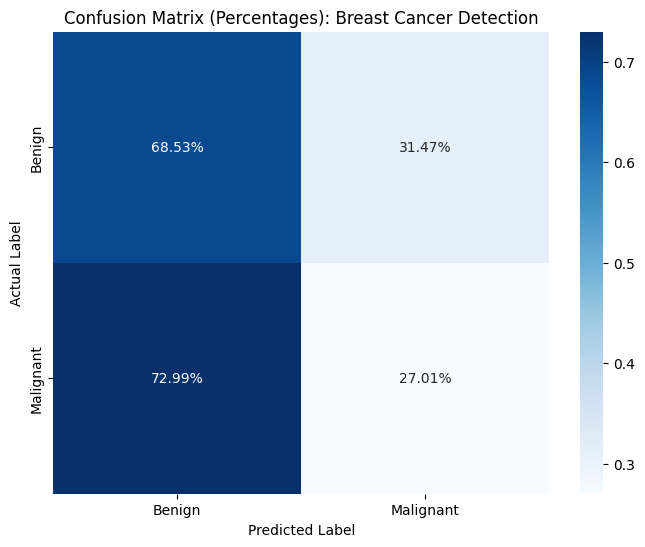

Classification Report
              precision    recall  f1-score   support

      Benign       0.48      0.69      0.57       448
   Malignant       0.46      0.27      0.34       448

    accuracy                           0.48       896
   macro avg       0.47      0.48      0.45       896
weighted avg       0.47      0.48      0.45       896



In [47]:
validation_set.reset()
Y_pred = model_3.predict(validation_set)
y_pred = np.argmax(Y_pred, axis=1)
y_true = validation_set.classes
# 2. Create the Confusion Matrix and Normalize it
# cm.sum(axis=1)[:, np.newaxis] divides each row by the total number of images in that class
cm = confusion_matrix(y_true, y_pred)
cm_perc = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] 

# 3. Plotting with Percentages
plt.figure(figsize=(8, 6))
sns.heatmap(cm_perc, annot=True, fmt='.2%', cmap='Blues', 
            xticklabels=classes, yticklabels=classes)

plt.title('Confusion Matrix (Percentages): Breast Cancer Detection')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# 4. Detailed Report
print('Classification Report')
print(classification_report(y_true, y_pred, target_names=classes))

#### train 3

In [28]:
from tensorflow.keras.layers import GlobalAveragePooling2D

# --- MODEL A: CUSTOM CNN ---
model_custom = Sequential([
    InputLayer(shape=[128, 128, 1]),
    
    Conv2D(32, 3, strides=2, padding='same', activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=2, padding='same'),
    Dropout(0.2),

    Conv2D(64, 3, padding='same', activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=2, padding='same'),
    Dropout(0.3),

    Conv2D(128, 3, padding='same', activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=2, padding='same'),
    Dropout(0.4),

    GlobalAveragePooling2D(), # Better than Flatten for preventing overfitting
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

model_custom.compile(optimizer=Adam(learning_rate=0.0001), 
                     loss='categorical_crossentropy', 
                     metrics=['accuracy'])

print("Training Custom CNN...")
history_custom = model_custom.fit(
    training_set,
    epochs=30,
    validation_data=validation_set,
    callbacks=[early_stop_3, reduce_lr_3]
)

Training Custom CNN...
Epoch 1/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 42s 189ms/step - accuracy: 0.5002 - loss: 0.9894 - val_accuracy: 0.4989 - val_loss: 0.6990 - learning_rate: 1.0000e-04
Epoch 2/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 23s 118ms/step - accuracy: 0.5249 - loss: 0.8812 - val_accuracy: 0.5201 - val_loss: 0.8732 - learning_rate: 1.0000e-04
Epoch 3/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.5197 - loss: 0.8966
Epoch 3: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
195/195 ━━━━━━━━━━━━━━━━━━━━ 23s 117ms/step - accuracy: 0.5236 - loss: 0.8884 - val_accuracy: 0.5357 - val_loss: 1.5081 - learning_rate: 1.0000e-04
Epoch 4/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 23s 116ms/step - accuracy: 0.5249 - loss: 0.8542 - val_accuracy: 0.5290 - val_loss: 2.3381 - learning_rate: 2.0000e-05
Epoch 5/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 25s 128ms/step - accuracy: 0.5272 - loss: 0.8737 - val_accuracy: 0.5212 - val_loss: 2.3803 - learning_rate: 2.0000e-05
Epoch 6/30
195/195 ━━━━━━━━━

#### train four

In [29]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, Model

# --- MODEL B: TRANSFER LEARNING ---
# We use 3 channels here because MobileNetV2 was trained on color images
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
base_model.trainable = False # Freeze the expert

# Create the input for grayscale
inputs = layers.Input(shape=(128, 128, 1))
# Convert grayscale (1 channel) to RGB (3 channels) so MobileNet is happy
x = layers.Concatenate()([inputs, inputs, inputs]) 
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(2, activation='softmax')(x)

model_transfer = Model(inputs, outputs)

model_transfer.compile(optimizer=Adam(learning_rate=0.0001), 
                       loss='categorical_crossentropy', 
                       metrics=['accuracy'])

print("\nTraining Transfer Learning Model...")
history_transfer = model_transfer.fit(
    training_set,
    epochs=30,
    validation_data=validation_set,
    callbacks=[early_stop_3, reduce_lr_3]
)


Training Transfer Learning Model...
Epoch 1/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 40s 175ms/step - accuracy: 0.5686 - loss: 0.8322 - val_accuracy: 0.6529 - val_loss: 0.6531 - learning_rate: 1.0000e-04
Epoch 2/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 30s 152ms/step - accuracy: 0.6114 - loss: 0.6726 - val_accuracy: 0.6696 - val_loss: 0.6275 - learning_rate: 1.0000e-04
Epoch 3/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 30s 152ms/step - accuracy: 0.6461 - loss: 0.6254 - val_accuracy: 0.6942 - val_loss: 0.6078 - learning_rate: 1.0000e-04
Epoch 4/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 30s 155ms/step - accuracy: 0.6586 - loss: 0.6092 - val_accuracy: 0.6808 - val_loss: 0.6212 - learning_rate: 1.0000e-04
Epoch 5/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 36s 185ms/step - accuracy: 0.6741 - loss: 0.5924 - val_accuracy: 0.6406 - val_loss: 0.6782 - learning_rate: 1.0000e-04
Epoch 6/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.6841 - loss: 0.5813
Epoch 6: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
195

Generating Predictions...
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 144ms/step


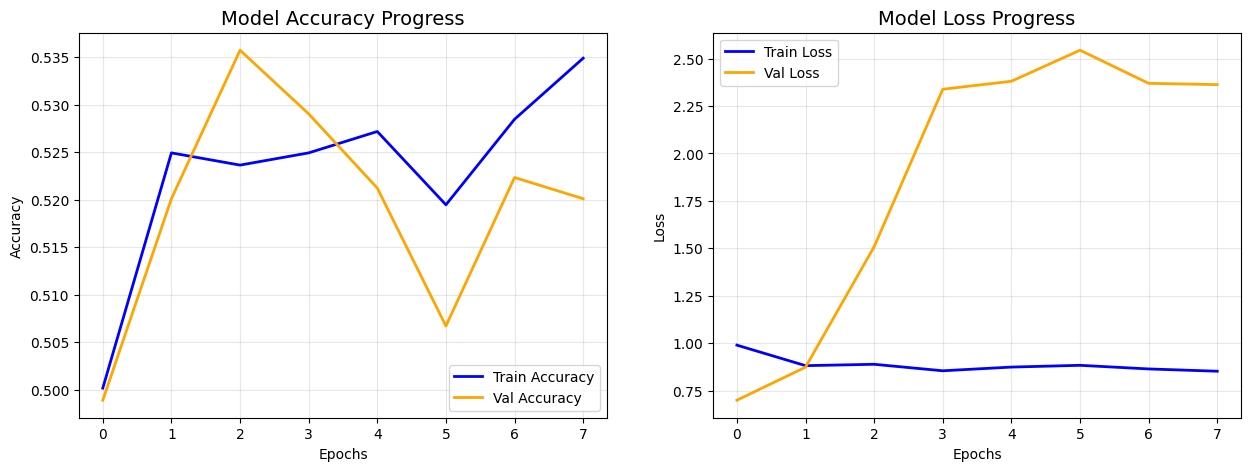

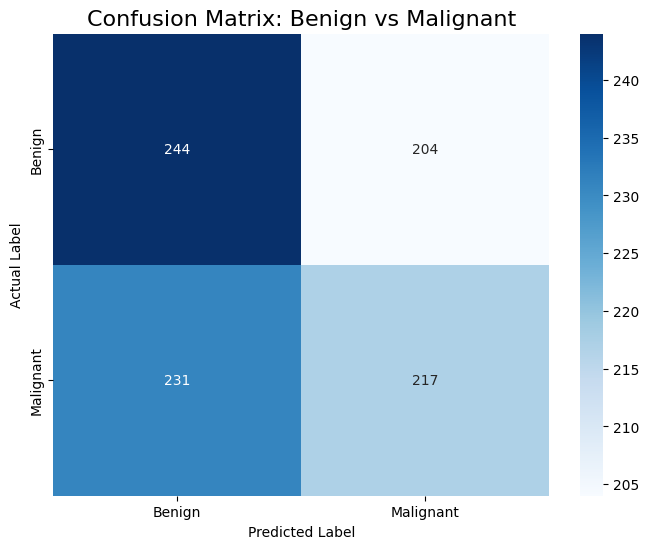


             DETAILED CLASSIFICATION REPORT
              precision    recall  f1-score   support

      Benign       0.51      0.54      0.53       448
   Malignant       0.52      0.48      0.50       448

    accuracy                           0.51       896
   macro avg       0.51      0.51      0.51       896
weighted avg       0.51      0.51      0.51       896



In [37]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# 1. Get Predictions
print("Generating Predictions...")
# We use validation_set but ensure it doesn't shuffle so labels match
validation_set.reset() 
Y_pred = model_custom.predict(validation_set)
y_pred = np.argmax(Y_pred, axis=1)
y_true = validation_set.classes
class_labels = list(validation_set.class_indices.keys())

# 2. Plot Training History (Loss & Accuracy)
plt.figure(figsize=(15, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_custom.history['accuracy'], label='Train Accuracy', color='blue', lw=2)
plt.plot(history_custom.history['val_accuracy'], label='Val Accuracy', color='orange', lw=2)
plt.title('Model Accuracy Progress', fontsize=14)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history_custom.history['loss'], label='Train Loss', color='blue', lw=2)
plt.plot(history_custom.history['val_loss'], label='Val Loss', color='orange', lw=2)
plt.title('Model Loss Progress', fontsize=14)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 3. The Confusion Matrix (The Heatmap)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix: Benign vs Malignant', fontsize=16)
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# 4. The Final Classification Report (Precision, Recall, F1)
print("\n" + "="*60)
print("             DETAILED CLASSIFICATION REPORT")
print("="*60)
print(classification_report(y_true, y_pred, target_names=class_labels))
print("="*60)

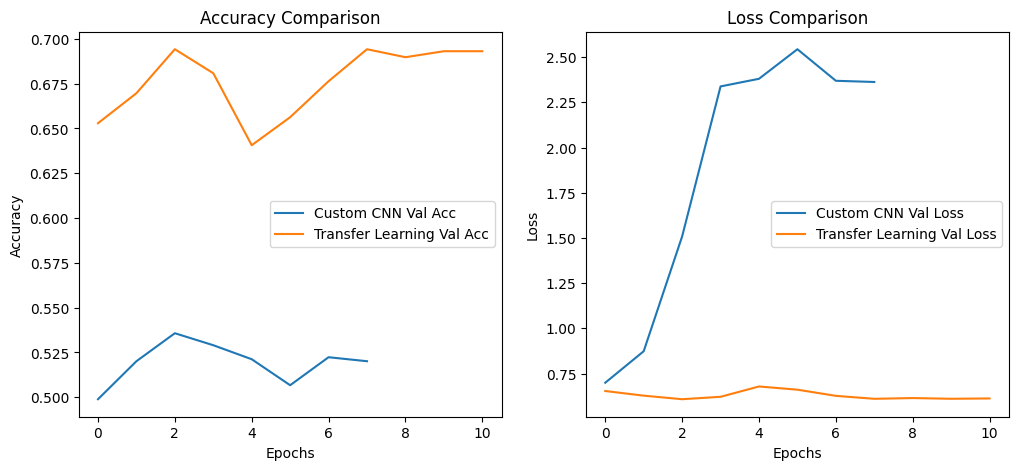

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_custom.history['val_accuracy'], label='Custom CNN Val Acc')
plt.plot(history_transfer.history['val_accuracy'], label='Transfer Learning Val Acc')
plt.title('Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history_custom.history['val_loss'], label='Custom CNN Val Loss')
plt.plot(history_transfer.history['val_loss'], label='Transfer Learning Val Loss')
plt.title('Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

#### Final Analysis 

56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step
Real class: Benign	Prediction: Malignant
Real class: Benign	Prediction: Malignant
Real class: Benign	Prediction: Malignant
Real class: Benign	Prediction: Malignant
Real class: Benign	Prediction: Malignant
Real class: Benign	Prediction: Benign
Real class: Benign	Prediction: Benign
Real class: Benign	Prediction: Malignant
Real class: Benign	Prediction: Malignant
Real class: Benign	Prediction: Malignant
Real class: Benign	Prediction: Malignant
Real class: Benign	Prediction: Malignant
Real class: Benign	Prediction: Malignant
Real class: Benign	Prediction: Malignant
Real class: Benign	Prediction: Malignant
Real class: Benign	Prediction: Malignant
Real class: Benign	Prediction: Malignant
Real class: Benign	Prediction: Benign
Real class: Benign	Prediction: Benign
Real class: Benign	Prediction: Malignant
Real class: Benign	Prediction: Benign
Real class: Benign	Prediction: Malignant
Real class: Benign	Prediction: Malignant
Real class: Benign	Prediction: B

array([448., 448.])

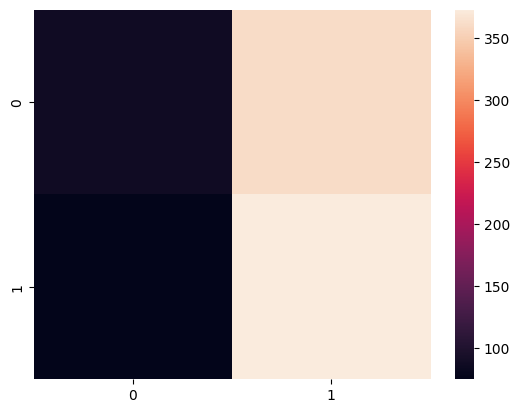

In [32]:
import seaborn as sn

testset = validation_set

predictions = model.predict(testset)

order = np.argsort(predictions)
conf = np.zeros([NUMCLASSES, NUMCLASSES])
count = 0

classcounts = np.zeros(NUMCLASSES)
for i in range(predictions.shape[0]):
    index = order[i,:]
    index = index[::-1]
    print('Real class:', reverse_class_labels[testset.labels[i]], end='\t')
    print('Prediction:',reverse_class_labels[index[0]])
    conf[testset.labels[i],index[0]] += 1
    classcounts[testset.labels[i]]+=1
    if testset.labels[i]==index[0]:
        count+=1
sn.heatmap(conf)
print(count)
classcounts  

<Axes: >

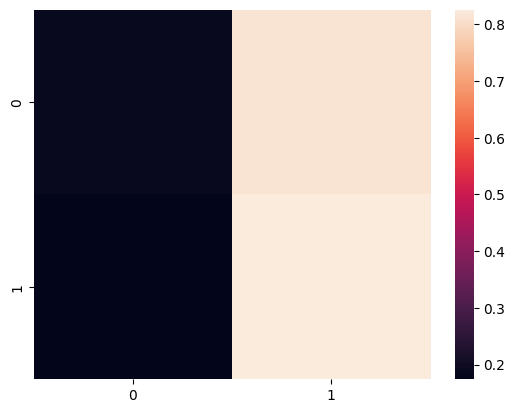

In [36]:
conf2 = np.copy(conf)
for i in range(conf2.shape[0]):
    conf2[i,:] /= classcounts[i]

sn.heatmap(conf2)

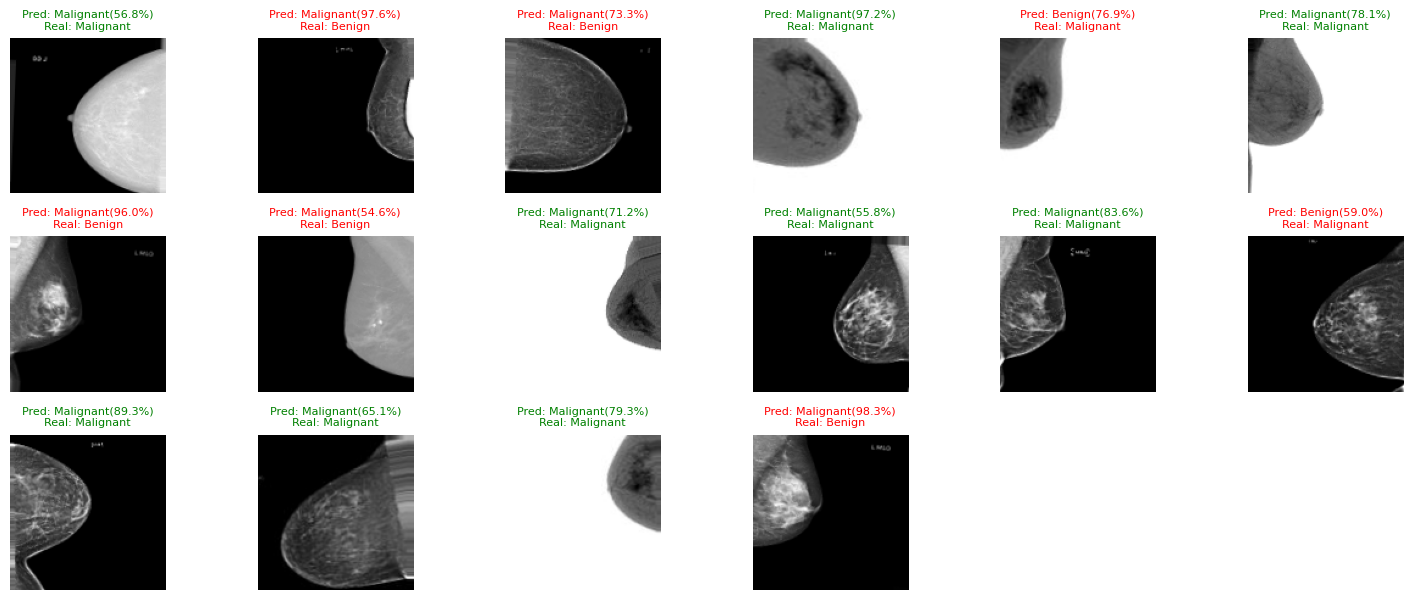

In [33]:
# Get one batch of training images and labels
images, labels = next(training_set)

# Limit to N images to show
N = 54
fig = plt.figure(figsize=(15, 18))

reverse_class_labels = {v: k for k, v in training_set.class_indices.items()}

for i in range(min(N, images.shape[0])):
    ax = fig.add_subplot(9, 6, i+1)

    # Prepare image for prediction
    img = images[i]
    img_input = img.reshape(1, INPUT_SIZE, INPUT_SIZE, 1)  # Add batch dimension

    # Make prediction
    prediction = model.predict(img_input, verbose=0)
    predicted_class_index = np.argmax(prediction)
    confidence = np.max(prediction) * 100
    
    # Get predicted label name
    realest_class_index = np.argmax(labels[i])
    realest_label_name = reverse_class_labels[realest_class_index]
    predicted_label_name = reverse_class_labels[predicted_class_index]
    

    # Show image with predicted label
    ax.imshow(img.squeeze(), cmap='gray')
    title_color = 'green' if predicted_class_index == realest_class_index else 'red'
    ax.set_title(f"Pred: {predicted_label_name}({confidence:.1f}%)\nReal: {realest_label_name}", fontsize=8, color = title_color)
    ax.axis('off')

plt.tight_layout()
plt.show()
